# Random Forest

The aim of this part of the workshop is to give you initial experience in using *random forests*, which is a popular ensemble method that was presented earlier in the lectures. A particular emphasis is given to the *out-of-bag* error (sometimes called out-of-sample error) that can be used to select random forest model complexity.


As a first step, setup the ipython notebook environment to include numpy, scipy, matplotlib etc.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In this tutorial, we are going to use synthetic data. You can also repeat steps of this worksheet with Cats dataset from the previous worksheet.

We are going to generate data using a function defined below. This function produces S-shaped dataset which is mostly separable, but not necessarily linearly separable. We can control the degree of separability. The resulting dataset is going to be two-dimensional (so that we can plot it) with a binary label. That is, the dataset is a $N\times2$ array of instances coupled with an $N\times1$ of labels. The classes are encoded as $-1$ and $1$.

Since the dataset is a tuple of two arrays, we are going to use a special data structure called *named tuple* from a Python module called *collections*.

In [2]:
import collections

def generate_s_shaped_data(gap=3):
    x = np.random.randn(80, 2)

    x[10:20] += np.array([3, 4])
    x[20:30] += np.array([0, 8])
    x[30:40] += np.array([3, 12])

    x[40:50] += np.array([gap, 0])
    x[50:60] += np.array([3 + gap, 4])
    x[60:70] += np.array([gap, 8])
    x[70:80] += np.array([3 + gap, 12])

    t = np.hstack([-np.ones(40), np.ones(40)])
    
    d = collections.namedtuple('Dataset', ['x', 't'])
    d.x = x
    d.t = t
    return d

We start with generating training data. A random forest is a non-linear model, so it's fine to generate data that is not linearly separable. 

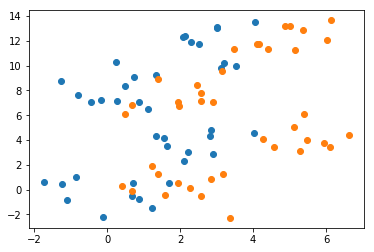

In [3]:
d = generate_s_shaped_data(2)
x = d.x
t = d.t

plt.plot(x[t==-1,0], x[t==-1,1], "o")
plt.plot(x[t==1,0], x[t==1,1], "o")

Next, we need to import modules that implement random forests. The current implementation yields a lot of annoying deprecation warnings that we don't need to care about in this tutorial. Therefore, we suppress the warnings.

In [4]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


Key parameters for training a random forest are the number of trees (*n_estimators*) and the number of features used in each iteration (*max_features*). First, we are going to train a random forest with only a few trees. Moreover, in this exercise, we are working with a simple 2D data, and there is not much room with features subset selection, so we are going to use both features. Note that *max_features=None* instructs the function to use all features.

In [5]:
model = RandomForestClassifier(n_estimators=5, max_features=None)
model.fit(x, t)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We now generate test data using the same setup as for the training data. In essense, this mimics the holdout validation approach where the dataset is randomly split in halves for training and testing. The test dataset should look similar, but not identical to the training data.

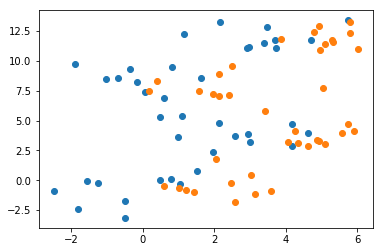

In [7]:
d = generate_s_shaped_data(2)
x_heldout = d.x
t_heldout = d.t

plt.plot(x_heldout[t_heldout==-1,0], x_heldout[t_heldout==-1,1], "o")
plt.plot(x_heldout[t_heldout==1,0], x_heldout[t_heldout==1,1], "o")

Let's see what the trained forest predicts for the test data. We will use an auxiliary variable $r$ as an indicator whether the prediction was correct. We will plot correcly classified points in blue and orange for both classes and misclassified points in black. Recall that this is the same test data as above, but instead of color-code labels, we show whether a point was misclassified or not.

Proportion misclassified:
0.3


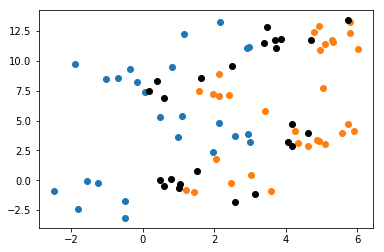

In [8]:
y = model.predict(x_heldout)
r = y+t_heldout
plt.plot(x_heldout[r==-2,0], x_heldout[r==-2,1], "o")
plt.plot(x_heldout[r==2,0], x_heldout[r==2,1], "o")
plt.plot(x_heldout[r==0,0], x_heldout[r==0,1], "ok")
print('Proportion misclassified:')
print(1 - np.sum(y == t_heldout) / float(t_heldout.shape[0]))

It looks like there are quite a few mistakes. Perhaps, this is because we are using too few trees. What do you expect to happen if we increase the number of trees? Try different values to see if you can achieve a perfect classification.

One way of choosing the number of trees would be to measure the error on the test set (heldout set) for different number of trees. However, recall from the lectures that out-of-bag (aka out-of-sample) error can be used to estimate the test error. The *error* here means the proportion of misclassified cases. We are going to use the out-of-bag error for choosing the number of trees. Note the *oob_score* parameter that instruct the function to remember the out-of-bag errors in each training iteration.

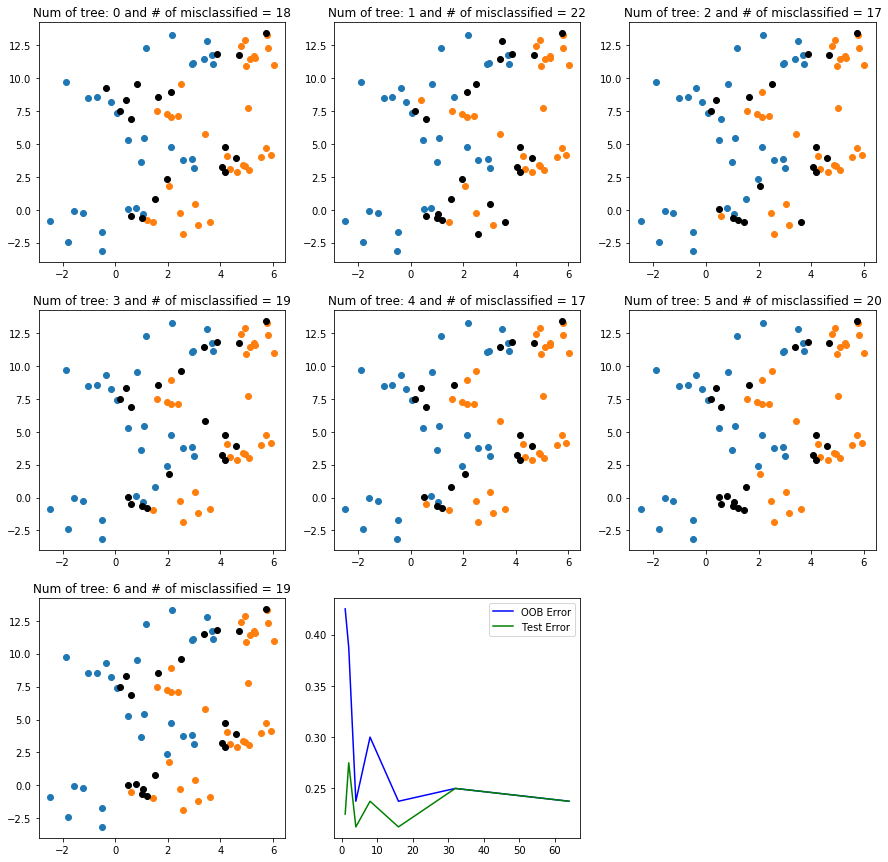

In [16]:
list_num_trees = [1, 2, 4, 8, 16, 32, 64]
num_cases = len(list_num_trees)
oob_error = np.zeros(num_cases)
test_error = np.zeros(num_cases)

rows = 3
cols = 3
fig1 = plt.figure(figsize=(rows*5,cols*5))
index = 1



for i in range(num_cases):
    model= RandomForestClassifier(n_estimators=list_num_trees[i], max_features=None, oob_score=True)
    model.fit(x, t)
    oob_error[i] = 1 - model.oob_score_
    y = model.predict(x_heldout)
    test_error[i] = 1 - np.sum(y == t_heldout) / float(t_heldout.shape[0])
    fig1.add_subplot(rows,cols,index)
    
    
    fig1.add_subplot(rows,cols,index)
    r = y+t_heldout
    plt.plot(x_heldout[r==-2,0], x_heldout[r==-2,1], "o")
    plt.plot(x_heldout[r==2,0], x_heldout[r==2,1], "o")
    plt.plot(x_heldout[r==0,0], x_heldout[r==0,1], "ok")
    plt.title('Num of tree: ' + str(list_num_trees[i]) +' and # of misclassified = ' + str(len(x_heldout[r==0,0])))
    index +=1

    
fig1.add_subplot(rows,cols,index)
plot(list_num_trees, oob_error, 'b',label = 'OOB Error')
plot(list_num_trees, test_error, 'g',label = 'Test Error')
plt.legend()
plt.show()   

print()

We can see that increasing the number of trees helps, but performance eventually stabilizes. Note that we only use training data for computing the out-of-bag error. Implement the heldout validation approach and compare the two errors as a function of number of trees.